In [ ]:
import json
import pandas as pd
from pathlib import Path

import json
import pandas as pd
from pathlib import Path

def stream_jsonl_to_parquet(jsonl_path, output_folder, batch_size=10000):
    buffer = []
    batch_num = 0

    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    print(f"Processing {jsonl_path}...")

    with open(jsonl_path, "r") as f:
        for i, line in enumerate(f):
            try:
                obj = json.loads(line)
                if obj.get("label") in [0, 1]:
                    buffer.append(obj)

                if len(buffer) >= batch_size:
                    df = pd.DataFrame(buffer)
                    output_path = output_folder / f"batch_{batch_num}.parquet"
                    df.to_parquet(output_path, index=False, engine="pyarrow", compression='snappy')
                    print(f"  Saved batch {batch_num} with {len(df)} rows to {output_path}")
                    buffer.clear()
                    batch_num += 1

                    break

            except json.JSONDecodeError as e:
                print(f"  Skipping line {i} due to JSON error: {e}")

    # Save any leftover rows
    if buffer:
        df = pd.DataFrame(buffer)
        output_path = output_folder / f"batch_{batch_num}.parquet"
        df.to_parquet(output_path, index=False, engine="pyarrow", compression='snappy')
        print(f"  Saved final batch {batch_num} with {len(df)} rows to {output_path}")

    print(f"Finished processing {jsonl_path}")


# Open and process the JSONL file
input_file = "F://ember//train_features_1.jsonl"
output_dir = "F://ember//parquet_batches"

stream_jsonl_to_parquet(input_file, output_dir)




In [ ]:
#df = pd.read_parquet("F://ember2018//parquet_batches_0//batch_0.parquet")
df = pd.read_parquet("F://ember//parquet_batches//batch_0.parquet")
row = df.iloc[0]

print(df.columns.tolist())
print(row["header"]["optional"].keys())

In [ ]:
import matplotlib.pyplot as plt

df["label"].value_counts().plot(kind="bar", title="Malware vs Benign Distribution")
plt.xticks(ticks=[0, 1], labels=["Benign (0)", "Malware (1)"])
plt.ylabel("Count")
plt.show()

In [ ]:
print(df.columns.tolist())
print(df.iloc[0])

In [4]:
from feature_extractors.pe_feature import PEFeatureExtractor


path = "C://Users//Alisa//Desktop//Unity app//CatKyu!! v3//CatKyu!!.exe"
with open(path, "rb") as f:
    bytez = f.read()
extractor = PEFeatureExtractor()

# Extract the raw feature dict
raw = extractor.raw_features(bytez)

# Turn it into a flat vector (normalized)
vector = extractor.process_raw_features(raw)

print("Feature vector shape:", vector.shape)
print("SHA256 of file:", raw['sha256'])
print("Extracted features: ", raw['imports'])
print("First 10 values of vector:", vector[:100])

Feature vector shape: (2351,)
SHA256 of file: 7bc58a214bb9c0f06a1ee0a7a3a0524f81653caf160b7084861ea6c6c8fd4e21
Extracted features:  {'UnityPlayer.dll': ['UnityMain'], 'KERNEL32.dll': ['HeapAlloc', 'WriteConsoleW', 'QueryPerformanceCounter', 'GetCurrentProcessId', 'GetCurrentThreadId', 'GetSystemTimeAsFileTime', 'InitializeSListHead', 'RtlCaptureContext', 'RtlLookupFunctionEntry', 'RtlVirtualUnwind', 'IsDebuggerPresent', 'UnhandledExceptionFilter', 'SetUnhandledExceptionFilter', 'GetStartupInfoW', 'IsProcessorFeaturePresent', 'GetModuleHandleW', 'CloseHandle', 'RtlUnwindEx', 'GetLastError', 'SetLastError', 'EnterCriticalSection', 'LeaveCriticalSection', 'DeleteCriticalSection', 'InitializeCriticalSectionAndSpinCount', 'TlsAlloc', 'TlsGetValue', 'TlsSetValue', 'TlsFree', 'FreeLibrary', 'GetProcAddress', 'LoadLibraryExW', 'EncodePointer', 'RaiseException', 'RtlPcToFileHeader', 'GetStdHandle', 'WriteFile', 'GetModuleFileNameW', 'GetCurrentProcess', 'ExitProcess', 'TerminateProcess', 'GetMo

In [1]:
import feature_extractors
data_dir = "F://ember_dataset//ember"

#feature_extractors.create_vectorized_features(data_dir)
X_train, y_train, X_test, y_test = feature_extractors.read_vectorized_features(data_dir)


In [2]:
import idk
import joblib

train_loader, val_loader, test_loader, scaler = idk.prepare_dataloaders(X_train, y_train, X_test, y_test)
joblib.dump(scaler, "scalers/scaler_v2_2017.pkl")

['scalers/scaler_v2_2017.pkl']

In [6]:
print(train_loader)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class DNN3(nn.Module):
    def __init__(self, input_dim=2351):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 2400),
            #nn.Dropout(0.5),
            nn.BatchNorm1d(2400),
            nn.ReLU(),

            #nn.Dropout(0.5),
            nn.Linear(2400, 1200),
            nn.BatchNorm1d(1200),  
            nn.ReLU(),
            
            nn.Linear(1200, 1200),
            nn.BatchNorm1d(1200),  
            nn.ReLU(),
            #nn.Linear(128, 64),
            #nn.ReLU(),
            #nn.BatchNorm1d(64),
            

            nn.Linear(1200, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class Model_v1_2017(nn.Module):
    def __init__(self, input_dim=2351):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.Dropout(0.5),
            nn.BatchNorm1d(2048),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),  
            nn.ReLU(),
            
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),  
            nn.ReLU(),
            #nn.Linear(128, 64),
            #nn.ReLU(),
            #nn.BatchNorm1d(64),
            

            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class FirstNN(nn.Module):
    def __init__(self, input_dim=2351):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

           
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class Model_v2_2017(nn.Module):
    def __init__(self, input_dim=2351):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

class FirstNNNoDropout(nn.Module):
    def __init__(self, input_dim=2351):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),

            
            nn.Linear(1500, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

----------Training on Model_v1_2017----------


Model_v1_2017(
  (net): Sequential(
    (0): Linear(in_features=2351, out_features=2048, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=2048, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=1024, out_features=1, bias=True)
    (12): Sigmoid()
  )
)
Epoch 1 | Train Loss: 0.2105 | Train Acc: 0.9141 | Val Loss: 0.0533 | Val Acc: 0.9806
Saved model
Epoch 2 | Train Loss: 0.0832 | Train Acc: 0.9698 | Val Loss: 0.0388 | Val Acc: 0.9855
Saved model
Epoch 3 | Train Loss: 0.0642 | Train Acc

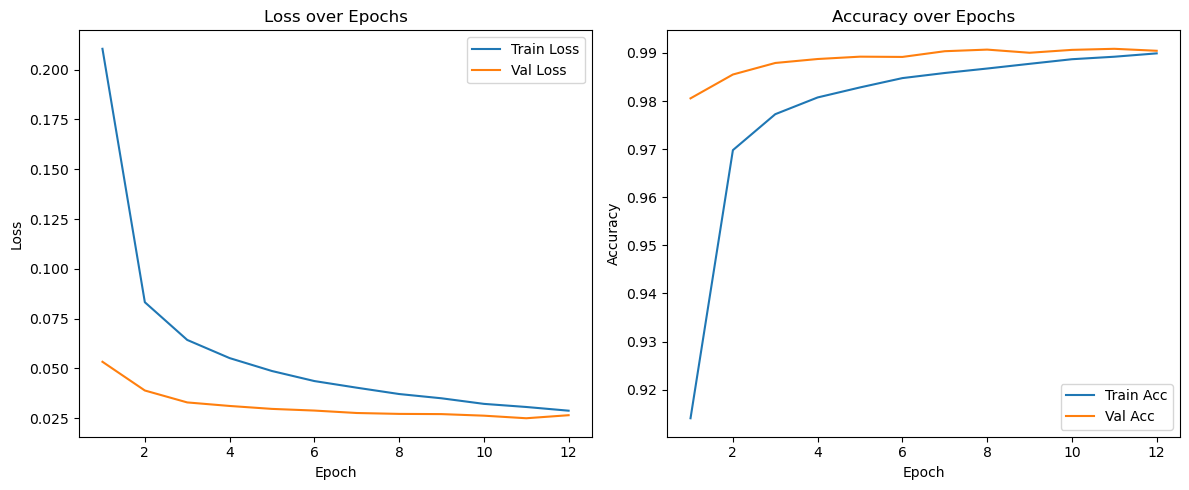

Test Accuracy: 0.986445
Test Precision: 0.984309
Test Recall: 0.988650
Test F1 Score: 0.986475
Test ROC AUC: 0.999122
AUC Score: 0.999122


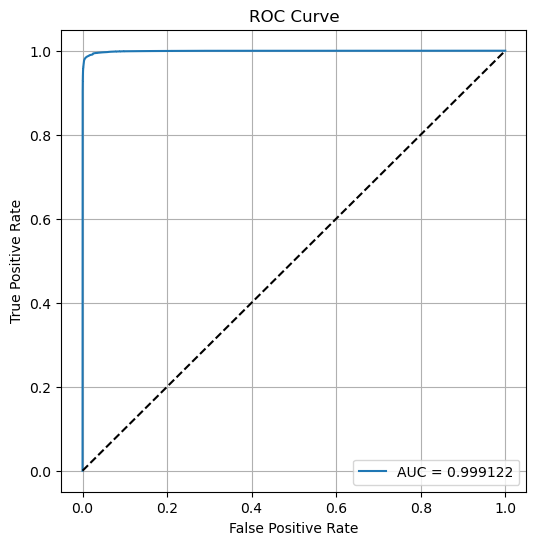

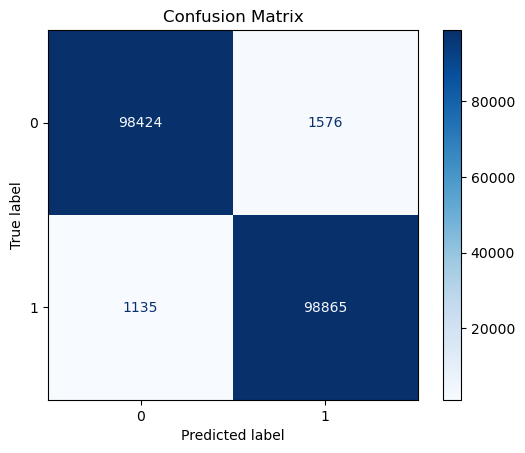

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [4]:
import torch.nn as nn
import torch.optim as optim
import idk

print("----------Training on Model_v1_2017----------\n\n")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model_v1_2017()
print(model)
results = idk.train_model(model, train_loader, val_loader, device, 20, 0.0001, "models/Model_v1_2017.pth")

idk.plot_training_metrics(
    results["train_losses"],
    results["val_losses"],
    results["train_accuracies"],
    results["val_accuracies"],
    model_name="Model_v1_2017"
)

test_results = idk.evaluate_model_on_test(model, test_loader, device)

idk.plot_roc_curve(test_results["labels"], test_results["probs"])
idk.plot_confusion_matrix(test_results["labels"], test_results["probs"])
idk.evaluate_at_fpr_thresholds(test_results["labels"], test_results["probs"], fpr_targets=[0.01, 0.001])

----------Training on Model_v2_2017----------


Model_v2_2017(
  (net): Sequential(
    (0): Linear(in_features=2351, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=256, out_features=1, bias=True)
    (17): Sigm

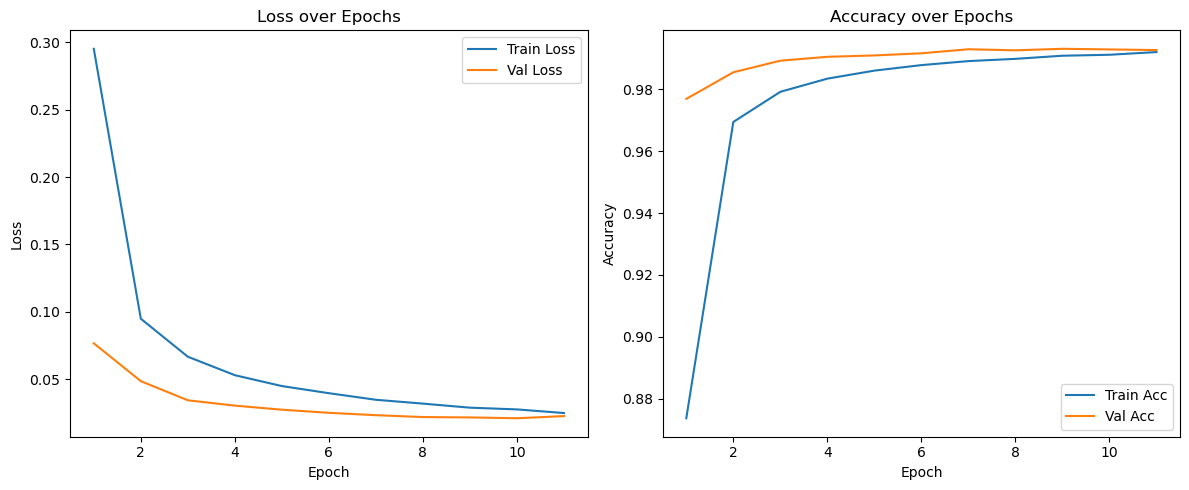

Test Accuracy: 0.988845
Test Precision: 0.990862
Test Recall: 0.986790
Test F1 Score: 0.988822
Test ROC AUC: 0.999186
AUC Score: 0.999186


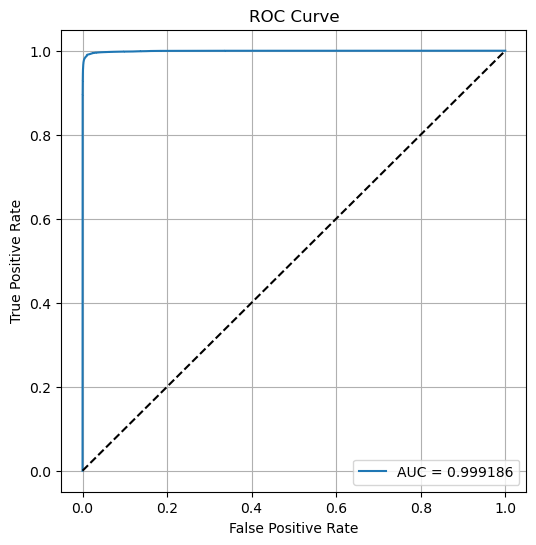

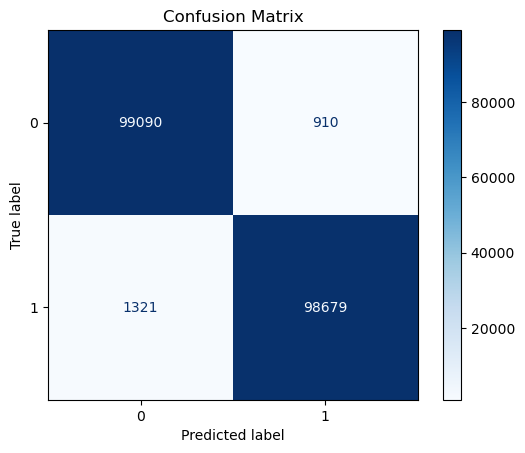

In [4]:
import torch.nn as nn
import torch.optim as optim
import idk

print("----------Training on Model_v2_2017----------\n\n")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model_v2_2017()
print(model)
results = idk.train_model(model, train_loader, val_loader, device, 20, 0.0001, "models/Model_v2_2017.pth")

idk.plot_training_metrics(
    results["train_losses"],
    results["val_losses"],
    results["train_accuracies"],
    results["val_accuracies"],
    model_name="Model_v2_2017"
)

test_results = idk.evaluate_model_on_test(model, test_loader, device)

idk.plot_roc_curve(test_results["labels"], test_results["probs"])
idk.plot_confusion_matrix(test_results["labels"], test_results["probs"])


In [ ]:
import torch.nn as nn
import torch.optim as optim
import idk

print("----------Training on Model_v1_2017_testing----------\n\n")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model_v1_2017()
print(model)
results = idk.train_model(model, train_loader, val_loader, device, 20, 0.0001, "models/Model_v1_2017_testing.pth")

idk.plot_training_metrics(
    results["train_losses"],
    results["val_losses"],
    results["train_accuracies"],
    results["val_accuracies"],
    model_name="Model_v1_2017_testing"
)

test_results = idk.evaluate_model_on_test(model, test_loader, device)

idk.plot_roc_curve(test_results["labels"], test_results["probs"])
idk.plot_confusion_matrix(test_results["labels"], test_results["probs"])


----------Training on Model_v1_2017_testing----------




NameError: name 'Model_v1_2017' is not defined

Model_v2_2017(
  (net): Sequential(
    (0): Linear(in_features=2351, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=256, out_features=1, bias=True)
    (17): Sigmoid()
  )
)
Test Accuracy: 0.988150
Test Precisi

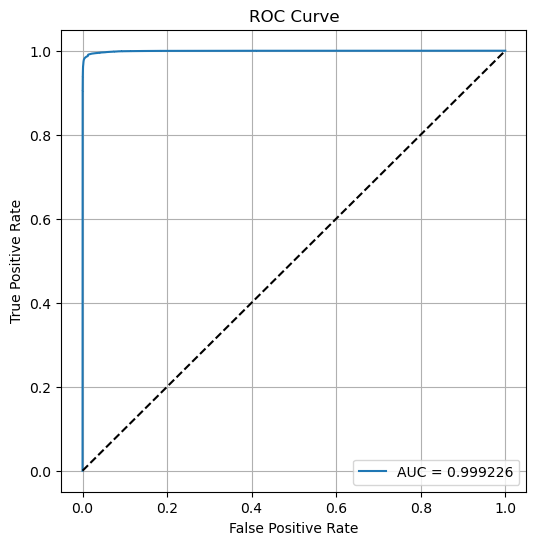

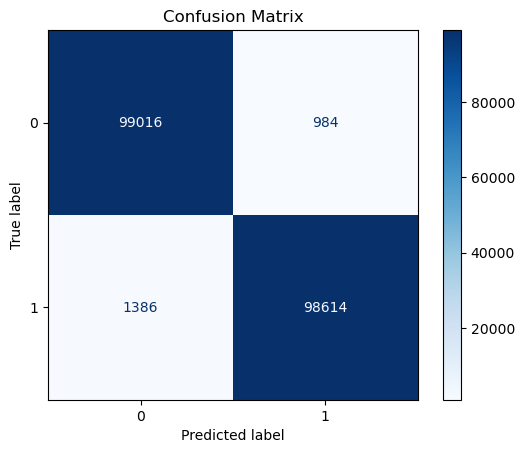


Performance at 1.0% FPR:
Threshold: 0.4827
False Positive Rate: 1.0000%
False Negative Rate: 1.3790%
Detection Rate (TPR): 98.6210%

Performance at 0.1% FPR:
Threshold: 0.9896
False Positive Rate: 0.1000%
False Negative Rate: 4.1880%
Detection Rate (TPR): 95.8120%


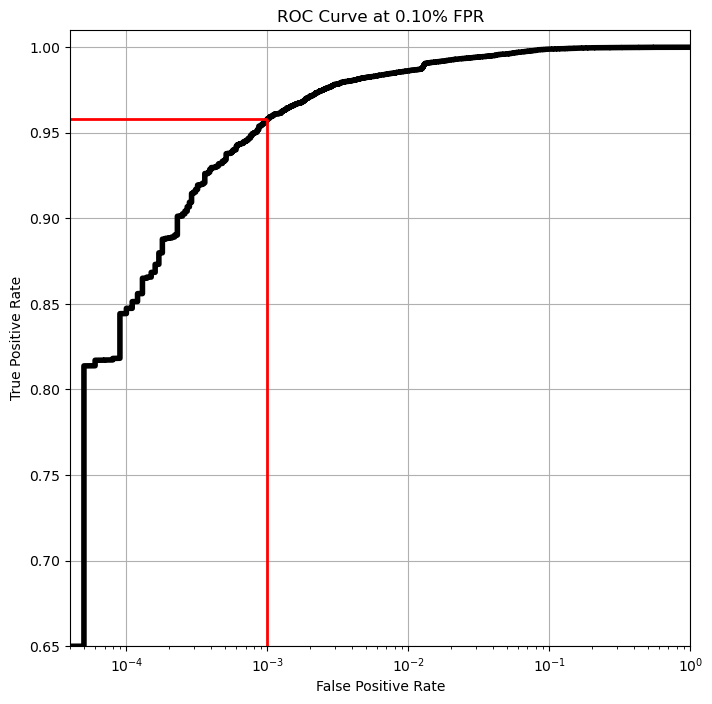

In [4]:
import torch.nn as nn
import torch.optim as optim
import idk

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model_v2_2017()
model.load_state_dict(torch.load("models/Model_v2_2017.pth"))
model.to(device)
print(model)
test_results = idk.evaluate_model_on_test(model, test_loader, device)

idk.plot_roc_curve(test_results["labels"], test_results["probs"])
idk.plot_confusion_matrix(test_results["labels"], test_results["probs"])
idk.evaluate_at_fpr_thresholds(test_results["labels"], test_results["probs"])

----------Training on Model_v2_2017_testing----------


Model_v2_2017(
  (net): Sequential(
    (0): Linear(in_features=2351, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=256, out_features=1, bias=True)
    (1

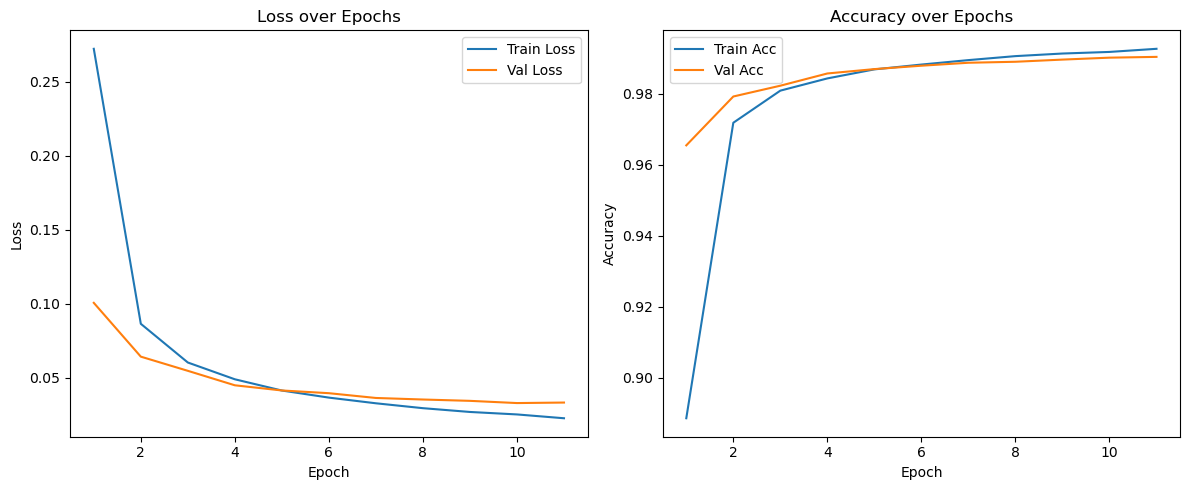

Test Accuracy: 0.990615
Test Precision: 0.991288
Test Recall: 0.989930
Test F1 Score: 0.990609
Test ROC AUC: 0.999274
AUC Score: 0.999274


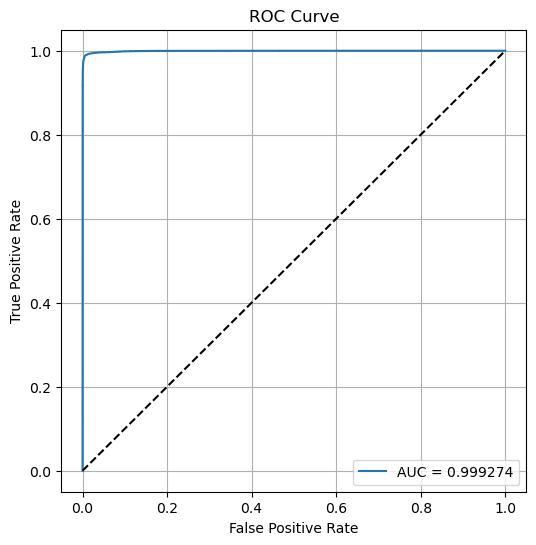

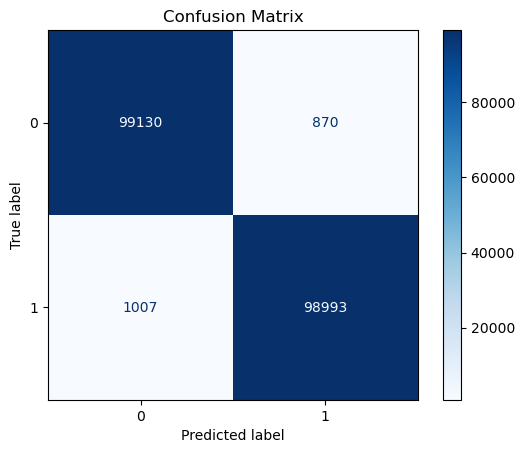


Performance at 1.0% FPR:
Threshold: 0.4162
False Positive Rate: 0.9990%
False Negative Rate: 0.9570%
Detection Rate (TPR): 99.0430%

Performance at 0.1% FPR:
Threshold: 0.9910
False Positive Rate: 0.0980%
False Negative Rate: 3.8400%
Detection Rate (TPR): 96.1600%


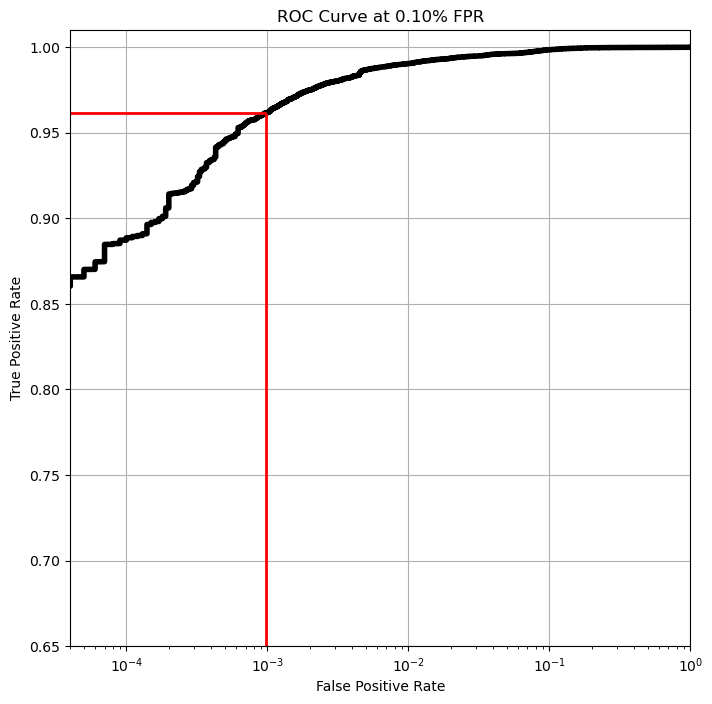

In [5]:
import torch.nn as nn
import torch.optim as optim
import idk

print("----------Training on Model_v2_2017_testing----------\n\n")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model_v2_2017()
print(model)
results = idk.train_model(model, train_loader, val_loader, device, 20, 0.0001, "models/Model_v2_2017_testing.pth")

idk.plot_training_metrics(
    results["train_losses"],
    results["val_losses"],
    results["train_accuracies"],
    results["val_accuracies"],
    model_name="Model_v2_2017_testing"
)

test_results = idk.evaluate_model_on_test(model, test_loader, device)

idk.plot_roc_curve(test_results["labels"], test_results["probs"])
idk.plot_confusion_matrix(test_results["labels"], test_results["probs"])
idk.evaluate_at_fpr_thresholds(test_results["labels"], test_results["probs"])


DNN


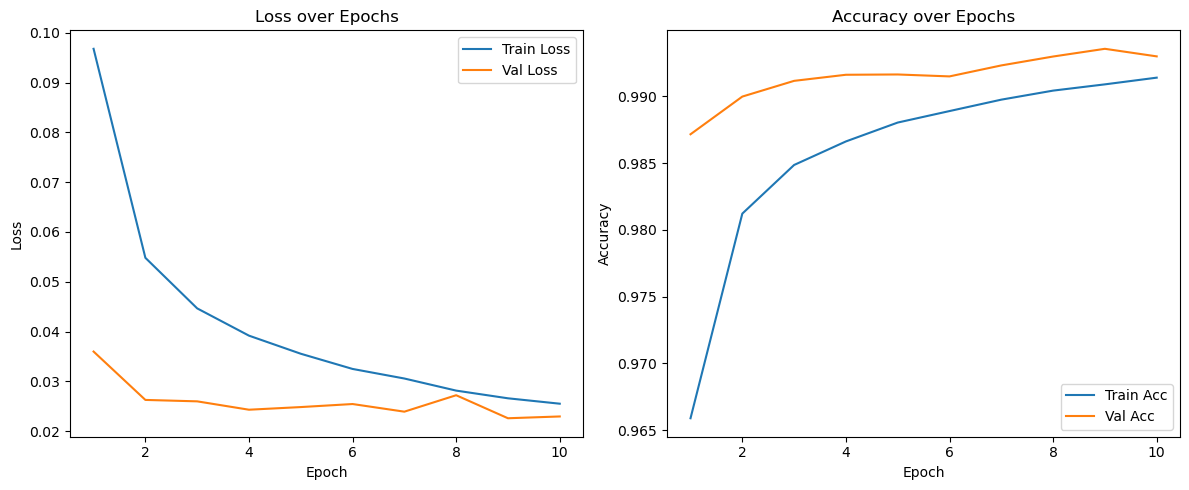

Test Accuracy: 0.5286
Test Precision: 0.5150
Test Recall: 0.9854
Test F1 Score: 0.6764
Test ROC AUC: 0.5295
AUC Score: 0.5295


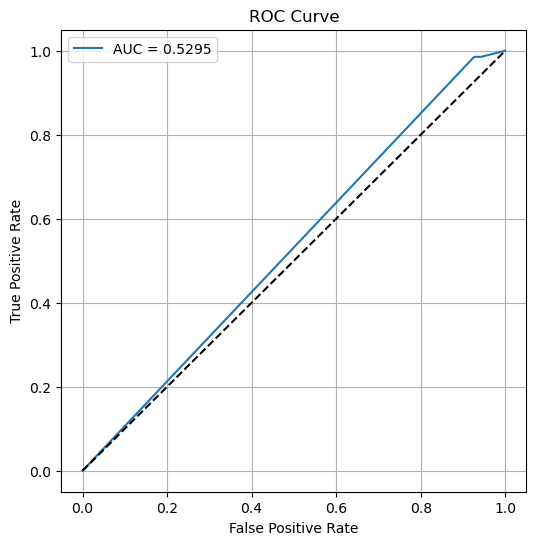

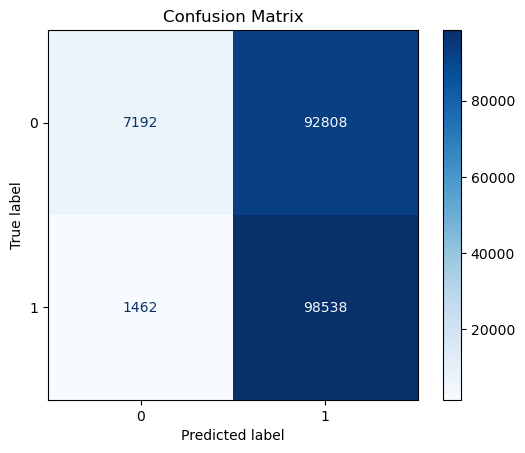

In [29]:
idk.plot_training_metrics(
    results["train_losses"],
    results["val_losses"],
    results["train_accuracies"],
    results["val_accuracies"],
    model_name="DNN"
)

from torch.utils.data import TensorDataset, DataLoader

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

test_results = idk.evaluate_model_on_test(model, test_loader, device)

idk.plot_roc_curve(test_results["labels"], test_results["probs"])
idk.plot_confusion_matrix(test_results["labels"], test_results["probs"])

In [33]:
import torch.nn as nn
import torch.optim as optim
import idk



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FirstNN()
results = idk.train_model(model, train_loader, val_loader, device, 10, 0.001, "firstNN2.pth")

Epoch 1 | Train Loss: 0.0783 | Train Acc: 0.9715 | Val Loss: 0.0328 | Val Acc: 0.9883
Saved model
Epoch 2 | Train Loss: 0.0464 | Train Acc: 0.9839 | Val Loss: 0.0247 | Val Acc: 0.9910
Saved model
Epoch 3 | Train Loss: 0.0359 | Train Acc: 0.9873 | Val Loss: 0.0244 | Val Acc: 0.9913
Saved model
Epoch 4 | Train Loss: 0.0311 | Train Acc: 0.9890 | Val Loss: 0.0242 | Val Acc: 0.9917
Saved model
Epoch 5 | Train Loss: 0.0287 | Train Acc: 0.9899 | Val Loss: 0.0287 | Val Acc: 0.9901
Epoch 6 | Train Loss: 0.0261 | Train Acc: 0.9907 | Val Loss: 0.0256 | Val Acc: 0.9914
Epoch 7 | Train Loss: 0.0236 | Train Acc: 0.9916 | Val Loss: 0.0221 | Val Acc: 0.9923
Saved model
Epoch 8 | Train Loss: 0.0224 | Train Acc: 0.9921 | Val Loss: 0.0241 | Val Acc: 0.9927
Epoch 9 | Train Loss: 0.0211 | Train Acc: 0.9925 | Val Loss: 0.0225 | Val Acc: 0.9926
Epoch 10 | Train Loss: 0.0199 | Train Acc: 0.9929 | Val Loss: 0.0227 | Val Acc: 0.9937


DNN


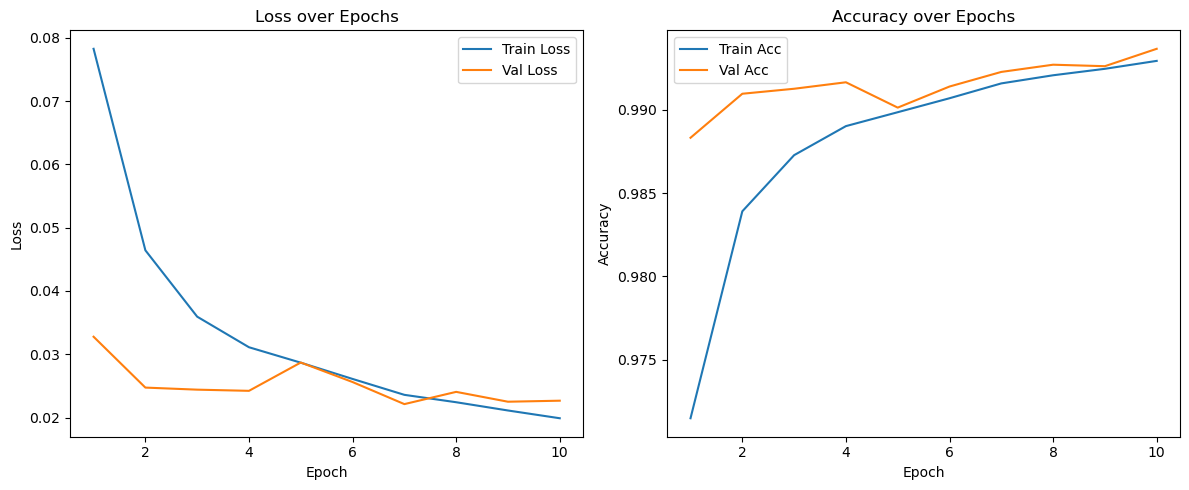

Test Accuracy: 0.5259
Test Precision: 0.5135
Test Recall: 0.9848
Test F1 Score: 0.6750
Test ROC AUC: 0.5265
AUC Score: 0.5265


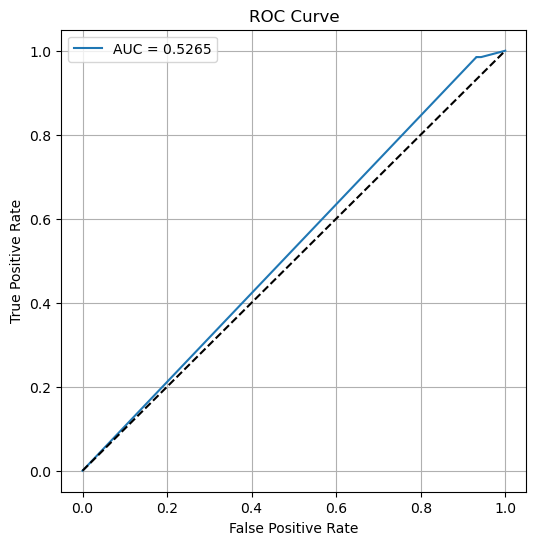

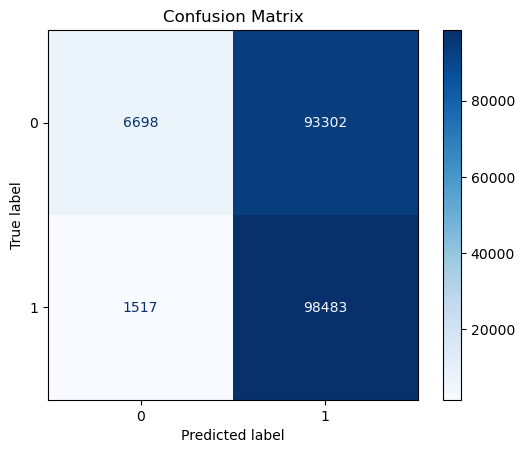

In [34]:
idk.plot_training_metrics(
    results["train_losses"],
    results["val_losses"],
    results["train_accuracies"],
    results["val_accuracies"],
    model_name="DNN"
)

from torch.utils.data import TensorDataset, DataLoader

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

test_results = idk.evaluate_model_on_test(model, test_loader, device)

idk.plot_roc_curve(test_results["labels"], test_results["probs"])
idk.plot_confusion_matrix(test_results["labels"], test_results["probs"])

In [5]:
import torch.nn as nn
import torch.optim as optim
import idk



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DNN3()
results = idk.train_model(model, train_loader, val_loader, device, 20, 0.0001, "DNN3.pth")

idk.plot_training_metrics(
    results["train_losses"],
    results["val_losses"],
    results["train_accuracies"],
    results["val_accuracies"],
    model_name="DNN3"
)

from torch.utils.data import TensorDataset, DataLoader

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8192, shuffle=False)

test_results = idk.evaluate_model_on_test(model, test_loader, device)

idk.plot_roc_curve(test_results["labels"], test_results["probs"])
idk.plot_confusion_matrix(test_results["labels"], test_results["probs"])

Epoch 1 | Train Loss: 0.1263 | Train Acc: 0.9525 | Val Loss: 0.0357 | Val Acc: 0.9885
Saved model
Epoch 2 | Train Loss: 0.0379 | Train Acc: 0.9874 | Val Loss: 0.0233 | Val Acc: 0.9926
Saved model
Epoch 3 | Train Loss: 0.0249 | Train Acc: 0.9919 | Val Loss: 0.0213 | Val Acc: 0.9925
Saved model
Epoch 4 | Train Loss: 0.0179 | Train Acc: 0.9943 | Val Loss: 0.0209 | Val Acc: 0.9933
Saved model
Epoch 5 | Train Loss: 0.0144 | Train Acc: 0.9955 | Val Loss: 0.0217 | Val Acc: 0.9935
Epoch 6 | Train Loss: 0.0124 | Train Acc: 0.9961 | Val Loss: 0.0217 | Val Acc: 0.9924
Epoch 7 | Train Loss: 0.0098 | Train Acc: 0.9969 | Val Loss: 0.0181 | Val Acc: 0.9944
Saved model


KeyboardInterrupt: 

FirstNN(
  (net): Sequential(
    (0): Linear(in_features=2351, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=256, out_features=1, bias=True)
    (17): Sigmoid()
  )
)


C:\Users\Alisa\AppData\Local\Temp\ipykernel_4680\655580116.py:14: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  X_test_tensor = torch.from_numpy(X_test).float()


Test Accuracy: 0.9880
Test Precision: 0.9913
Test Recall: 0.9847
Test F1 Score: 0.9880
Test ROC AUC: 0.9987
AUC Score: 0.9987


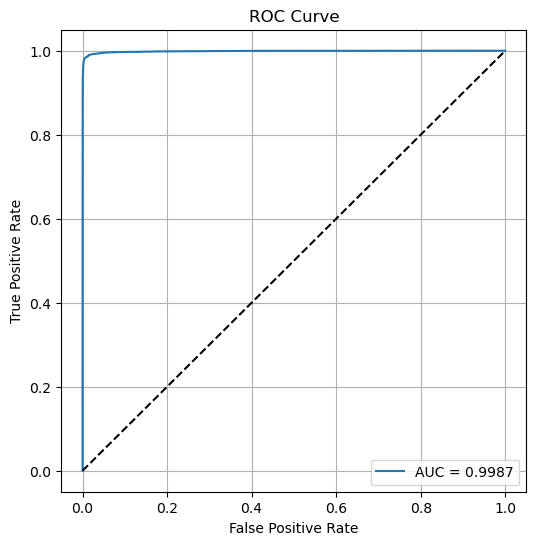

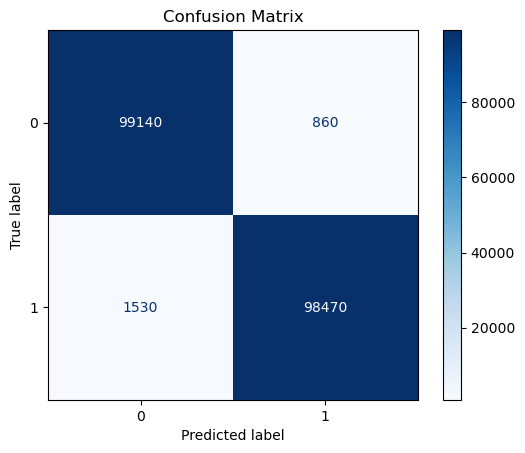